# Random Forest Regression

In this exercise, we are using machine learning as a tool for data exploration. We are interested in discovering the impact of the other features (attributes) on PM10 dust concentration. One way to investigate this is to implement a PM10 predictor that uses the other features as input and then check the contribution of each attribute to the learning algorithm. Our algorithm of chocie is [random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) due to the interpretability of the outcome. 

*Random forest* is an ensemble algorithm, a class of learning algorithms that rely on combining the predictions of many 'weak' learners instead of relying on a single 'strong' learner. In practice, this approach is used to avoid the common issue of overfitting, where a learning algorithm fits the given dataset too well. In short, an overfit algorithm goes beyond just learning the nature and statistical properties data, it learns the particular intricacies of the specific examples in the dataset. Hence, it deviates from learning the trends in the data and learning the irrelevant noise in it. In other words, an overfit algorithm loses sight of the forest for the trees. The aptly named random forest algorithm instead uses an ensemble of learners, called decision trees, that are trained to lean towards under-fitting rather than over-fitting and uses the consensus of these weak learners to come to a final decision. 

The *decision trees* that make up the random forest abstract the idea of a flowchart, mimicking a natural way humans make decisions. The training of a decision tree starts at the root node and at every step asks the question, "What is the most distinctive feature and how does it distinguish the target variable?". Based on the answer, the tree branches and keeps iteratively asking the same question at each branch for the subset of data that lands on the given side. Thinking back to out primary goal with this cookbook, the decision trees are internally asking the same questions that we do.      

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor 

In [5]:
# We are loading the edited version of the dataset we saved in the first section.
dust_df = pd.read_csv('./saharan_dust_met_cat_vars.csv', index_col='time')

# Similar to the PCA example, we need to one-hot encode the wind direction since random forests only support numerical features.
one_hot = pd.get_dummies(dust_df['WIND_DIR'])
dust_df = dust_df.drop('WIND_DIR', axis=1)
dust_df = dust_df.join(one_hot)

# Separating our data into the target variable (PM10) and the features (the rest fo the attributes)
y = dust_df['PM10'].values
X = dust_df.drop(['PM10'], axis=1).values

A key step in training learning algorithms is the *hyperparameter tuning* step. These parameters specify the predictor we are using and can be used as levers to fine tune how well the algorithm fits the given dataset. These chocies are critical in preventing under-fitting and over-fitting in most learning algorithms. However, due to our choice of a resilient ensemble algorithm, these choices end up being less impactful than other algorithms like neural networks or a stand-alone decision-tree. We include the best performing choices of the parameters in our attempts, but feel free to change these values to see how they imapct the rest of our analysis. 

Below is a quick summary of how the most significant hyper-parameters impact the resultant random forest. For much more detail, you can find the in-depth [user guide](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).
* `n_estimators`: This is the number of decision-trees included in the random forest. The larger the number, the more robust we expect the algorithm to get to overfitting, which comes at a computational cost during training.

* `max_depth`: The maximum depth for the decision-trees in the algorithm. The deeper the tree gets, the more likely it is to over-fit (and conversely, the shallower the tree, the more likely it is to under-fit). Using an ensemble of trees instead of a single one reduces the impact of this hyper-parameter.

* `max_features`: The number of features each branch can make decisions on. The larger the number, the likelier a tree is to over-fit and vice versa. Similar to `max_depth`, using random forest makes it less crucial to tune this parameter well. We leave it at its default value.

* `n_jobs`: Enables training decision-trees in parallel. Our choices maximizes the parallelisim to complete training as fast as possible. 

In [6]:
rf = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1)

# This step might take a few minutes. We slice the data into 5 random chunks.
# Then, each chunk is spared for testing, the training is done on the other 4 and tested on the spared chunk.
# This is repeated 5 times and the average of the result is reported. 
scores = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_absolute_percentage_error")
print(f"The random forest predicts the dust level with {scores.mean()+1} average accuracy")

The random forest predicts the dust level with 0.6050630988493501 average accuracy


For evaluation, we are using a relative metric. The reported loss value is the relative difference (w.r.t to the true value) between the true and the predicted value. So, the ~60% accuracy we get here means our prediction deviates from the true value by 40% on average. Although this figure looks large at first glance, notice that the target value varies across a large range that makes orders of magnitude mistakes possible.  

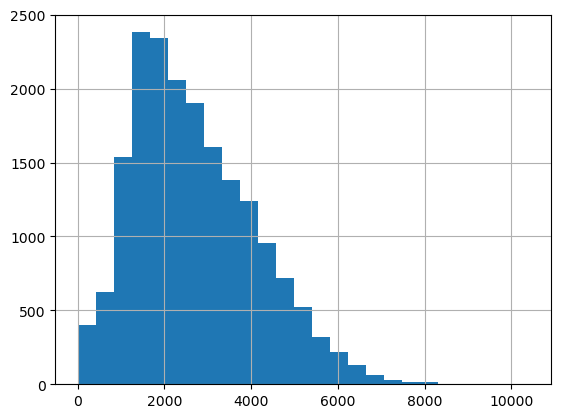

In [7]:
dust_df['PM10'].hist(bins=25);

This step is a typical part of the machine learning workflow for tuning hyper-parameters. Once we finalize the hyper-parameters, we can re-train the algorithm on all of our data (instead of 4/5 of it) and start exploring te importance of the features on our target variable.

In [9]:
# Training a new random forest on our entire data
y = dust_df['PM10'].values
X = dust_df.drop(['PM10', 'wind_speed_10m'], axis=1).values
rf = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1)
rf.fit(X, y);

A very useful property of random forests is their interpretability. As useful as they are in practice, quite a lot of learning algorithms are hard to interpret once they are trained. Although there are exceptions, artificial neural networks are hard to make sense of despite their impressive performance, making them practical black-boxes. Random forests on the other hand, keep track of the importance of each feature and the ranges of each that dictate the target variable. We use this information to rank how our features impact the `PM10` dust levels.

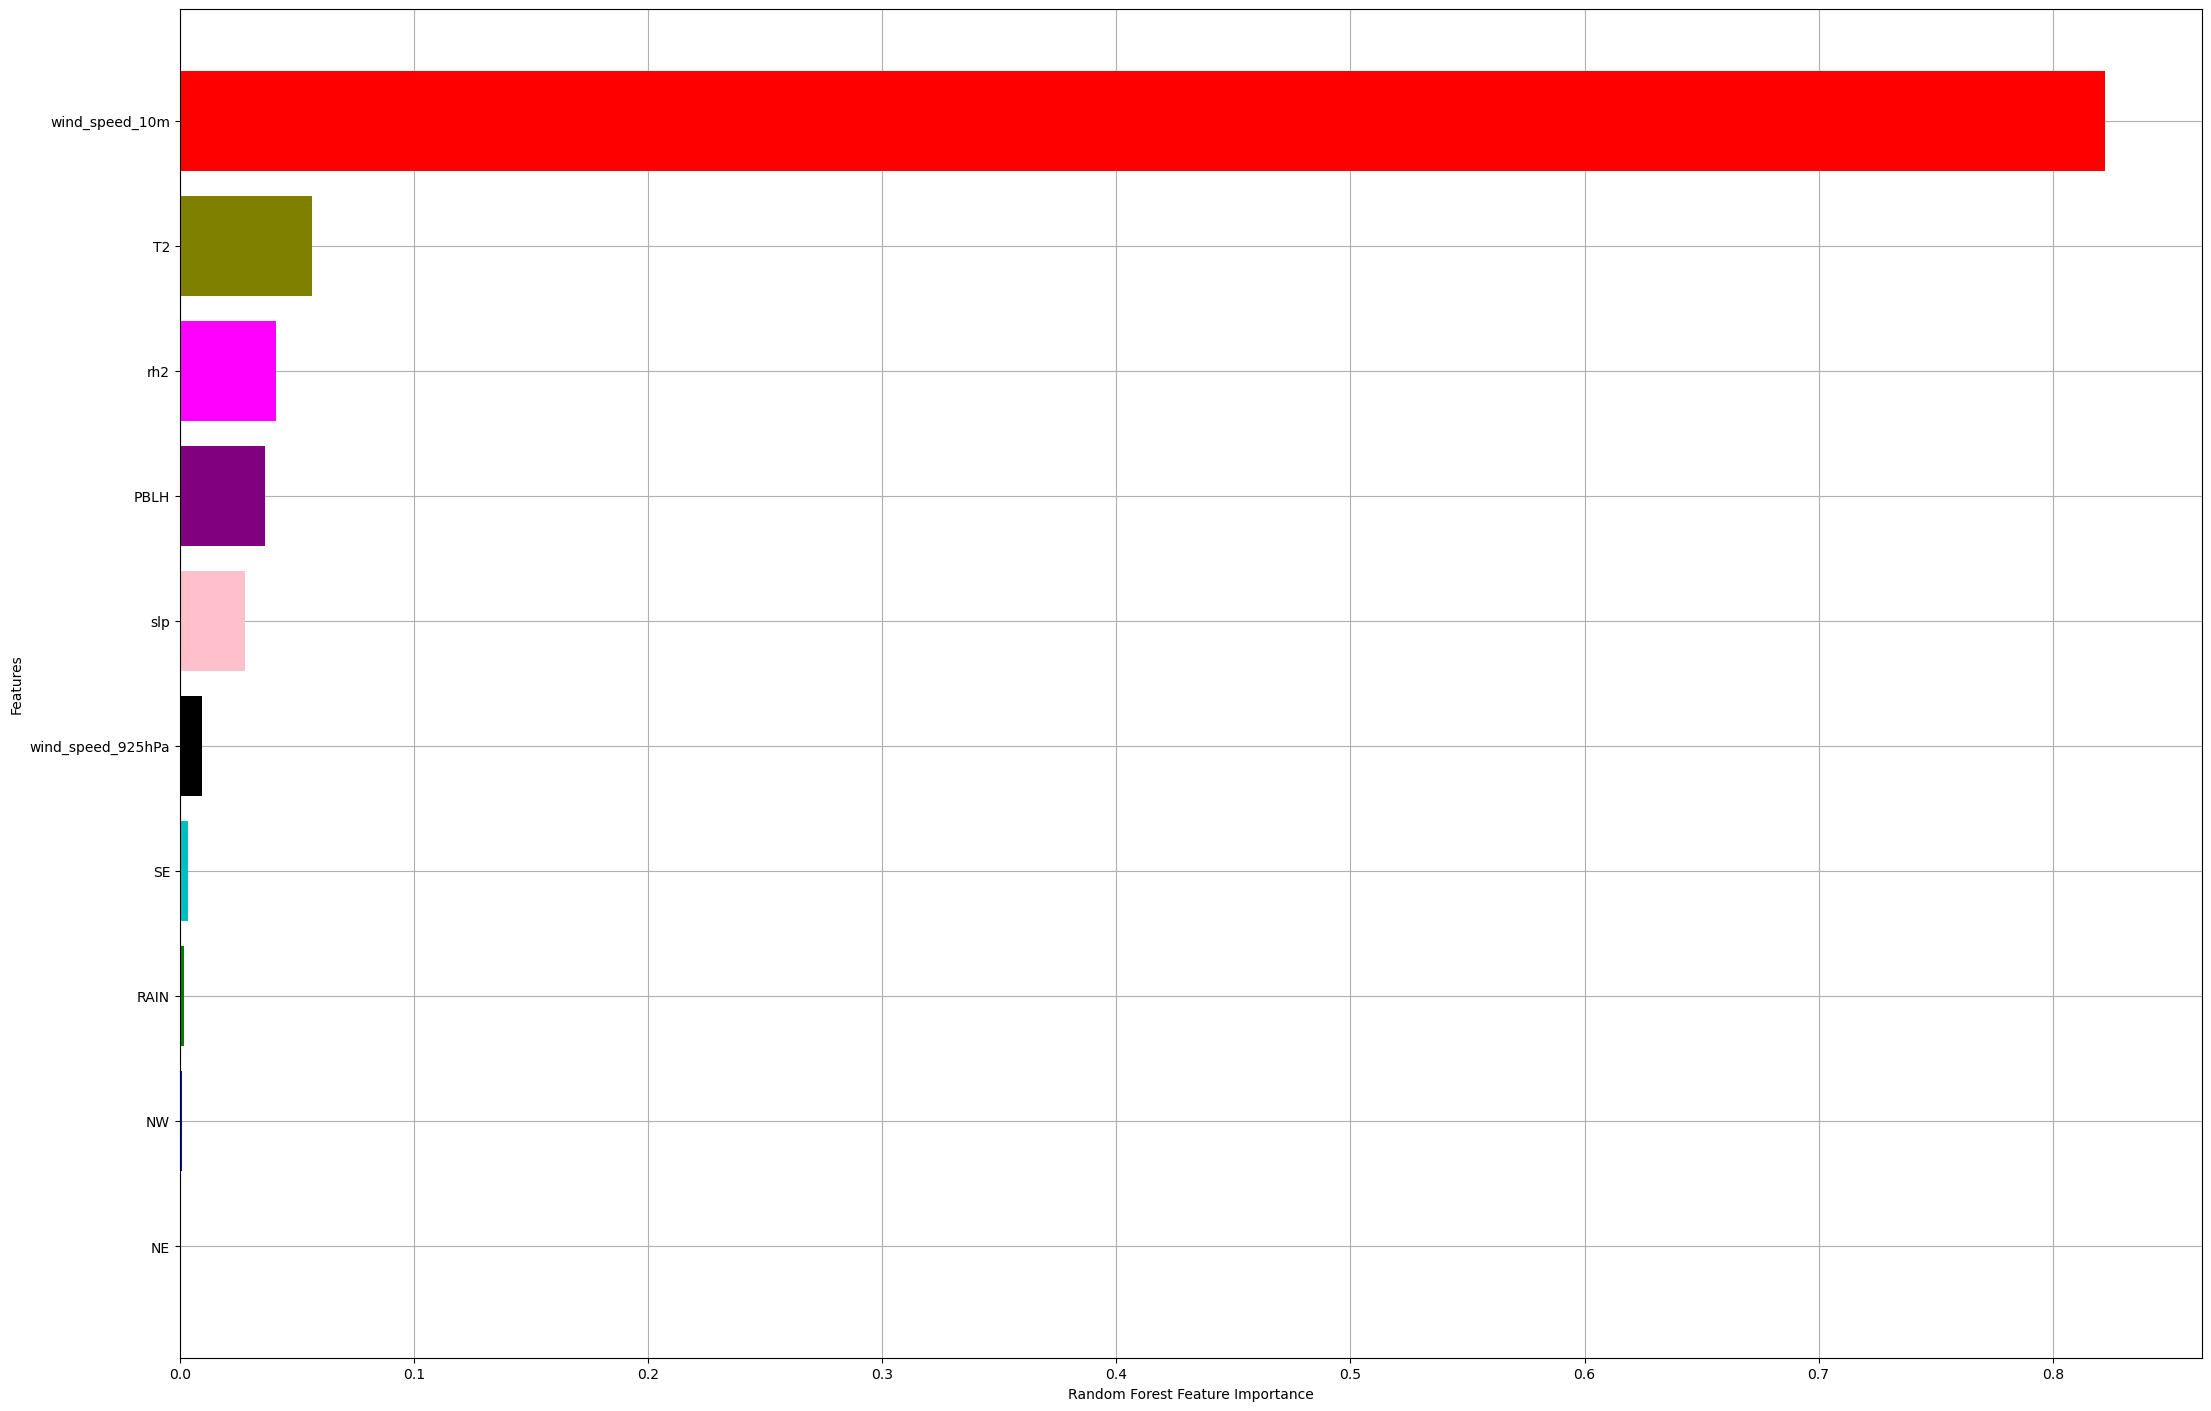

In [17]:
fig, ax = plt.subplots(1,1, figsize=(22,14), sharex=False, sharey=False,
                               constrained_layout=True)
sorted_idx = rf.feature_importances_.argsort()
importances = rf.feature_importances_
x_values = list(features.columns)

# Make a bar chart
cols = np.array(['r','b','g','c','k','pink','purple','magenta','olive'])
ax.set_xlabel('Random Forest Feature Importance')
ax.set_ylabel('Features')
ax.set_axisbelow(True)
ax.grid()
ax.barh(features.columns[sorted_idx],
           importances[sorted_idx], color=cols);

We see in this figure the significant impact of the wind speed at 10 meters. However, this dominance overshadows the impact of the other featsures. To see how important each feature is, we use the accuracy of our predictor that has all the features as the baseline and re-train predictors by ;eaving one feature out at a time. Then, comparing the performance of these predictors with the benchmark can help us quantify how much our predictor's performance changes by including each feature.

In [23]:
benchmark_accuracy = scores.mean()
leave_one_out_accuracies = []

# We exclude the one-hot encoded features
leave_one_out_features = ['T2', 'rh2', 'slp', 'PBLH', 'wind_speed_10m', 'wind_speed_925hPa','RAIN']

for feat in leave_one_out_features:
    dropped_labels = ['PM10']
    dropped_labels.append(feat)
    features = dust_df.drop(dropped_labels, axis=1)
    X = dust_df.drop(dropped_labels, axis=1).values
    rf = RandomForestRegressor(n_estimators=100, max_depth=100, n_jobs=-1);
    current_scores = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_absolute_percentage_error")
    leave_one_out_accuracies.append(current_scores.mean())
    print(f"The random forest predicts the dust level with {current_scores.mean()+1} accuracy when we leave {dropped_labels[1]} out")

The random forest predicts the dust level with 0.5895556590123748 accuracy when we leave T2 out
The random forest predicts the dust level with 0.576661022569276 accuracy when we leave rh2 out
The random forest predicts the dust level with 0.6365825821292022 accuracy when we leave slp out
The random forest predicts the dust level with 0.5854103094187407 accuracy when we leave PBLH out
The random forest predicts the dust level with 0.5406798226808214 accuracy when we leave wind_speed_10m out
The random forest predicts the dust level with 0.6042490546473329 accuracy when we leave wind_speed_925hPa out
The random forest predicts the dust level with 0.6140872310658637 accuracy when we leave RAIN out


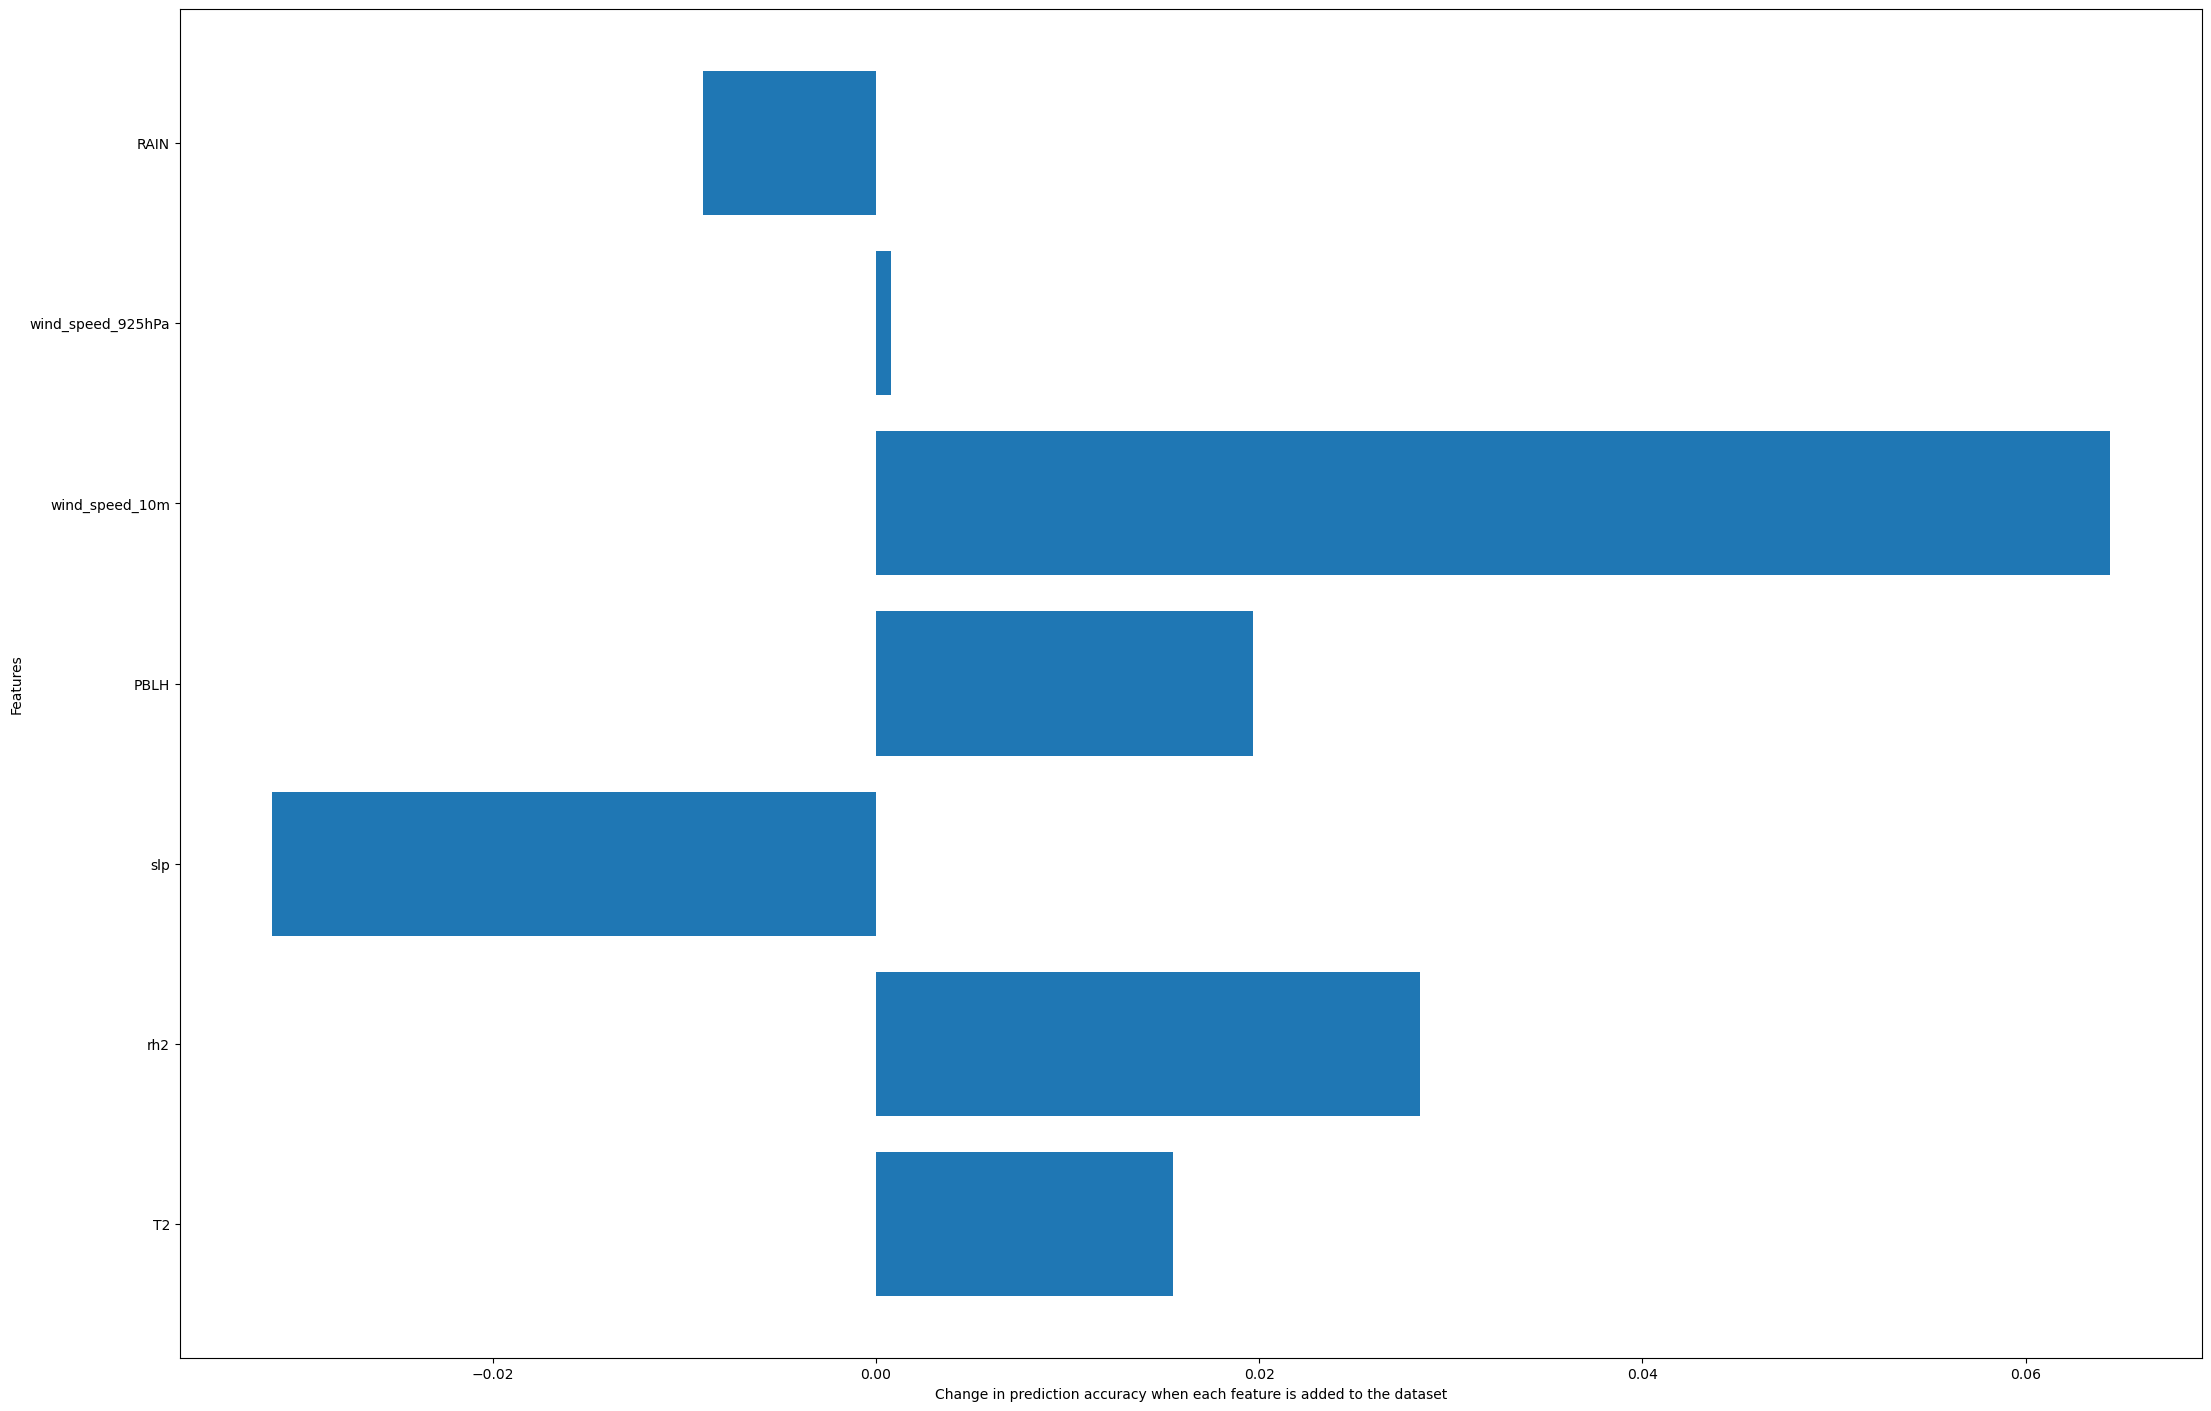

In [26]:
fig, ax = plt.subplots(1,1, figsize=(22,14), sharex=False, sharey=False, constrained_layout=True);
ax.barh(leave_one_out_features, [benchmark_accuracy-loo for loo in leave_one_out_accuracies]);
ax.set_xlabel('Change in prediction accuracy when each feature is added to the dataset');
ax.set_ylabel('Features');